<a href="https://colab.research.google.com/github/RaiqaRasool/ml_training/blob/main/9_Tensor_Grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For understand autograd in detail refer to this: [Understanding Autograd: 5 Pytorch tensor functions](https://medium.com/@namanphy/understanding-autograd-5-pytorch-tensor-functions-8f47c27dc38)

**Chain Rule:** As the name suggests, chain rule means differentiating the terms one by one in a chain form, starting from the outermost function to the innermost function

#Basic Overview

In [ ]:
import torch

# Step 1: Define input tensor x and weight tensor a with requires_grad=True
x = torch.tensor([2.0], requires_grad=True)
a = torch.tensor([3.0], requires_grad=True)

# Step 2: Forward pass - Multiply the input by the weight
b = x * a

# Step 3: Forward pass - Add a constant value
c = b + 2

# Step 4: Compute the loss (mean squared error loss)
target = torch.tensor([10.0])
loss = (c - target).pow(2)

# Step 5: Backward pass - Compute gradients
loss.backward()

# Step 6: Print gradients
print("Gradient of x:", x.grad)
print("Gradient of a:", a.grad)


Gradient of x: tensor([-12.])
Gradient of a: tensor([-8.])


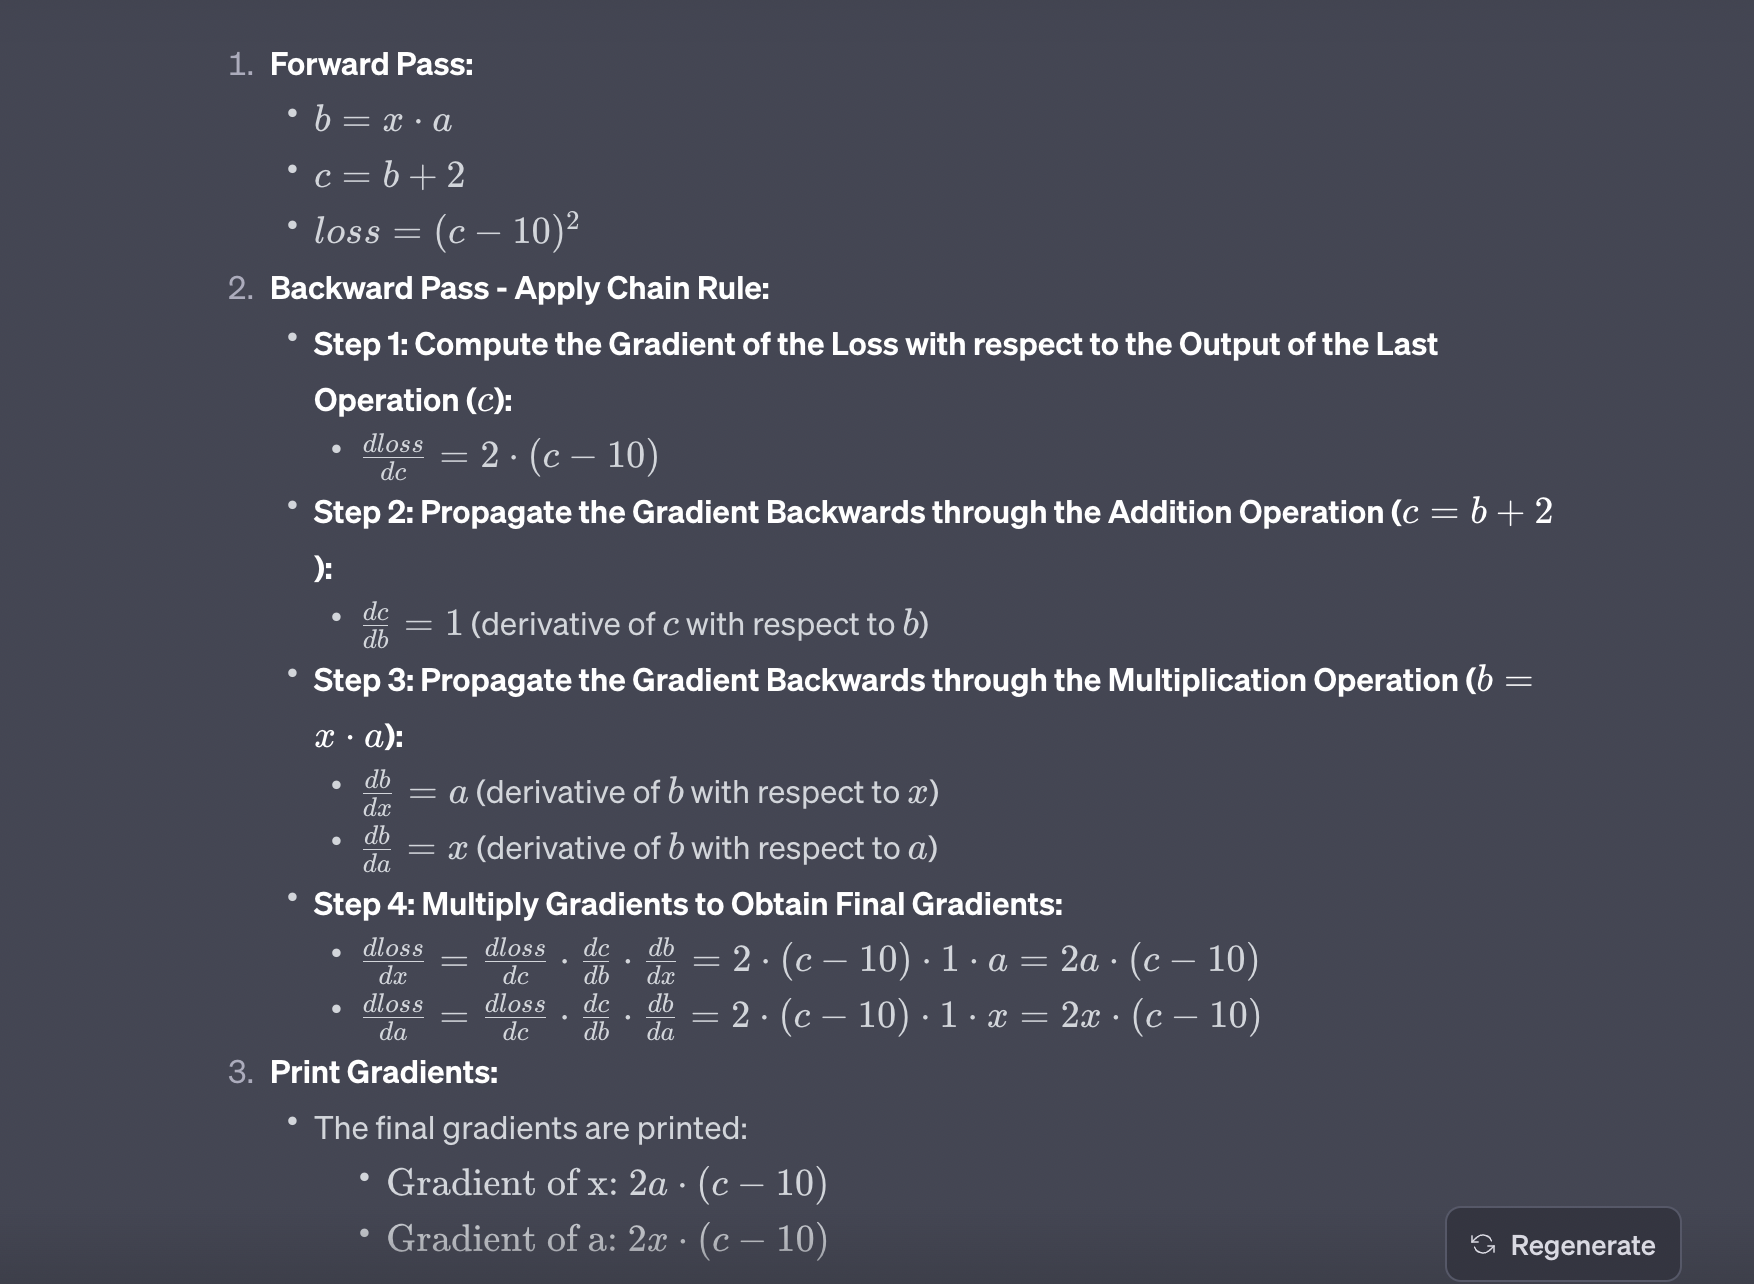

These gradients indicate how much the loss would change with respect to small changes in the input tensors x and a.

# Autograd playing

## Backward use

`.grad for a variable will fill only when .backward is called on that variable or on the variable that is being derived from it `

## .grad filling by calling .backward on variable

In [ ]:
c=torch.tensor([1.],requires_grad=True)
d=torch.tensor([3.],requires_grad=True)
c.grad,d.grad

(None, None)

In [ ]:
c.backward()
c.grad,d.grad

(tensor([1.]), None)

In [ ]:
d.backward()
c.grad,d.grad

(tensor([1.]), tensor([1.]))

## .grad filling by calling .backward on variable that is derived from current variable

In [ ]:
e=torch.tensor([7.],requires_grad=True)
f= torch.tensor([8.],requires_grad=True)
g=2*e
h= 3*f

In [ ]:
g.backward()

In [ ]:
e.grad,f.grad # dg/de , dh/df

(tensor([2.]), None)

In [ ]:
h.backward()
e.grad,f.grad # dg/de, dh/df

(tensor([2.]), tensor([3.]))

In [ ]:
e=torch.tensor([7.],requires_grad=True)
f= torch.tensor([8.],requires_grad=True)
g=2*e
h= 3*f
i=g*h # i = 6ef
i.backward()
e.grad,f.grad # di/de, di/df

(tensor([48.]), tensor([42.]))

# Basic neural network implementation
For manual calculations of this neural network refer to this blog: [A Step by Step Backpropagation Example
](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

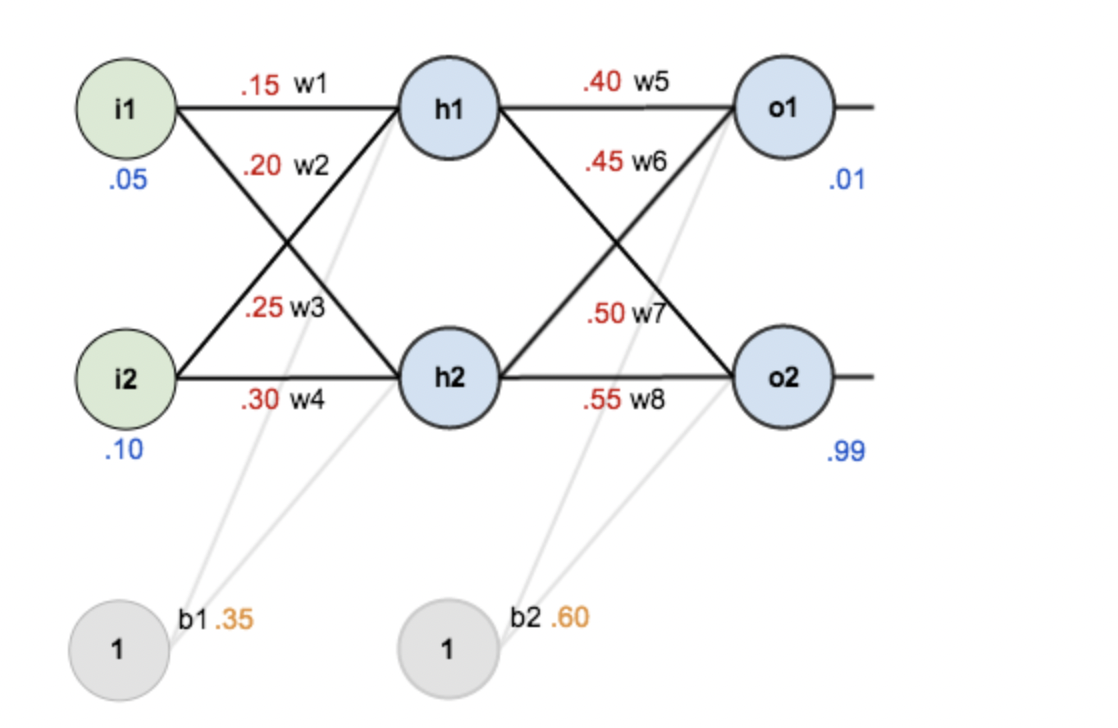

### Simple implementation

### Parameters Initialization

In [ ]:
inputs=torch.tensor([
    [0.05],
    [0.10]
                     ])
weights_h= torch.tensor([
    [0.15,0.20],
    [0.25, 0.30]
],requires_grad=True)
biases_h=torch.tensor([
    [0.35],
    [0.35]
],requires_grad=True)
weights_out= torch.tensor([
    [0.40,0.45],
    [0.50, 0.55]
],requires_grad=True)
biases_out=torch.tensor([
    [0.60],
    [0.60]
],requires_grad=True)
targets=torch.tensor([
    [0.01],
    [0.99]
],requires_grad=True)

#### Activation (Sigmoid) Function

In [ ]:
def activation(out):
  return 1/(1 + torch.exp(-out))

#### Hidden Layer

In [ ]:
net_h=torch.matmul(weights_h,inputs)  + biases_h
net_h

tensor([[0.3775],
        [0.3925]], grad_fn=<AddBackward0>)

In [ ]:
out_h=activation(net_h)
out_h

tensor([[0.5933],
        [0.5969]], grad_fn=<MulBackward0>)

#### Output Layer

In [ ]:
net_output=torch.matmul(weights_out,out_h) + biases_out
net_output

tensor([[1.1059],
        [1.2249]], grad_fn=<AddBackward0>)

In [ ]:
out_output= activation(net_output)
out_output

tensor([[0.7514],
        [0.7729]], grad_fn=<MulBackward0>)

#### Loss Calculations

In [ ]:
loss=((out_output-targets).pow(2))/2
loss

tensor([[0.2748],
        [0.0236]], grad_fn=<DivBackward0>)

####Backpropogation

In [ ]:
loss.backward(torch.tensor([[1.],[1.]]))

In [ ]:
weights_h.grad,weights_out.grad

(tensor([[0.0004, 0.0009],
         [0.0005, 0.0010]]),
 tensor([[ 0.0822,  0.0827],
         [-0.0226, -0.0227]]))

In [ ]:
biases_h.grad,biases_out.grad

(tensor([[0.0088],
         [0.0100]]),
 tensor([[ 0.1385],
         [-0.0381]]))

### Model with Training

In [ ]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

In [ ]:
def forward_pass(inputs):
  global weights_h
  global weights_out
  global biases_h
  global biases_out

  net_h=torch.matmul(weights_h,inputs)+biases_h
  out_h=sigmoid(net_h)
  net_o=torch.matmul(weights_out,out_h) + biases_out
  out_o=sigmoid(net_o)

  return out_o

In [ ]:
def find_loss(predicted,target):
  return torch.mean((predicted - target)**2)

In [ ]:
def optimize(loss,lr_rate):
  global weights_h
  global weights_out
  global biases_h
  global biases_out

  loss.backward()
  with torch.no_grad():
    weights_h -= (lr_rate* weights_h.grad)
    weights_out -=  (lr_rate* weights_out.grad)
    biases_h -= (lr_rate* biases_h.grad)
    biases_out -= (lr_rate* biases_out.grad)

  # print("---Weights after optimization--")
  # print('weights_h: ',weights_h)
  # print('weights_out: ',weights_out)
  # print('biases_h: ',biases_h)
  # print('biases_out: ',biases_out)

**Important:** `torch.no_grad()` is used as a context manager to ensure that the operations inside it don't track gradients. The detach method is not needed here, as using torch.no_grad() achieves the same goal of detaching the computation from the computation graph. Additionally, gradients are manually zeroed after each optimization step to avoid accumulating them across multiple iterations. This way, the weights remain leaf nodes for future updates.


**Error:**

weights_h.grad becomes None for second epoch in case of using:

```
weights_h=weights_h - (lr_rate* weights_h.grad)
```

instead of:

```
weights_h-=(lr_rate* weights_h.grad)
```

*Explaination:* https://stackoverflow.com/questions/60166866/attributeerror-nonetype-object-has-no-attribute-zero

In [ ]:
## Network details
inputs=torch.tensor([
    [0.05],
    [0.10]
                     ])
weights_h= torch.tensor([
    [0.15,0.20],
    [0.25, 0.30]
],requires_grad=True)
biases_h=torch.tensor([
    [0.35],
    [0.35]
],requires_grad=True)
weights_out= torch.tensor([
    [0.40,0.45],
    [0.50, 0.55]
],requires_grad=True)
biases_out=torch.tensor([
    [0.60],
    [0.60]
],requires_grad=True)
targets=torch.tensor([
    [0.01],
    [0.99]
],requires_grad=True)

### Training

for i in range(10): # 10 epochs
  output = forward_pass(inputs)
  loss= find_loss(output,targets)
  print(f"=========== Epoch {i+1} =================")
  print(f"Predicted: ",output)
  print(f"Loss: ", loss)
  optimize(loss,0.5)


=========== Epoch 1 =================
Predicted:  tensor([[0.7514],
        [0.7729]], grad_fn=<MulBackward0>)
Loss:  tensor(0.2984, grad_fn=<MeanBackward0>)
=========== Epoch 2 =================
Predicted:  tensor([[0.7284],
        [0.7784]], grad_fn=<MulBackward0>)
Loss:  tensor(0.2805, grad_fn=<MeanBackward0>)
=========== Epoch 3 =================
Predicted:  tensor([[0.6783],
        [0.7888]], grad_fn=<MulBackward0>)
Loss:  tensor(0.2436, grad_fn=<MeanBackward0>)
=========== Epoch 4 =================
Predicted:  tensor([[0.5944],
        [0.8031]], grad_fn=<MulBackward0>)
Loss:  tensor(0.1882, grad_fn=<MeanBackward0>)
=========== Epoch 5 =================
Predicted:  tensor([[0.4751],
        [0.8204]], grad_fn=<MulBackward0>)
Loss:  tensor(0.1226, grad_fn=<MeanBackward0>)
=========== Epoch 6 =================
Predicted:  tensor([[0.3370],
        [0.8393]], grad_fn=<MulBackward0>)
Loss:  tensor(0.0648, grad_fn=<MeanBackward0>)
=========== Epoch 7 =================
Predicted:  te

In [ ]:
weights_h,weights_out

(tensor([[0.1474, 0.1948],
         [0.2461, 0.2922]], requires_grad=True),
 tensor([[-1.3850, -1.3440],
         [ 0.9596,  1.0118]], requires_grad=True))